#### This notebook demonstrates how to generate images of handwritten digits using a `Deep Convolutional Generative Adversarial Network`.

#### The code is written using the Keras Sequential API with a `tf.GradientTape`

- Two models are trained simultaneously by an adversarial process. 

- A generator `artist` learns how to create images that look real while a discriminator `the art critic` learns how to tell real images from the fake ones.

This notebook demonstratesthis process on the MNIST dataset.

In [1]:
import os
import PIL
import time
import glob
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from IPython import display

2022-07-11 19:02:14.967259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-11 19:02:14.967297: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Load and preprocess the dataset.
BUFFER_SIZE = 60_000
BATCH_SIZE = 256

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 #Normalize images to [-1, 1]

#Batch and shuffle the data.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset.element_spec

2022-07-11 19:02:21.413890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-11 19:02:21.413937: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-11 19:02:21.413967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debonair): /proc/driver/nvidia/version does not exist
2022-07-11 19:02:21.414327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-11 19:02:21.415925: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 

TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)

## 2. Create the models.

#### Both the genrator and discriminator are defined using the `keras Sequential API.`

#### a) The Generator.
- The genrator uses the `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with the `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image of `28 * 28 * 1`. 

- Notice that the `tf.keras.layers.LeakyReLU` activation for each layer, except for the output layer which uses the `tanh` activation layer.

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units = 7 * 7 * 256, use_bias = False, input_shape = (100, )))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) #None is the batch size.
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 7, 7, 128)
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 14, 14, 64)
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

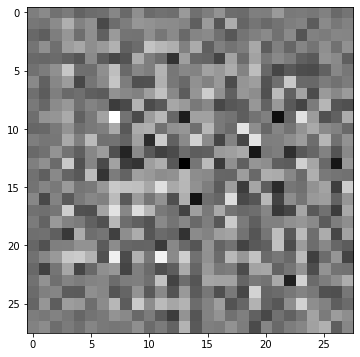

In [4]:
#Use the untrained generator to create an image.
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

plt.figure(figsize = (6, 6))
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')
plt.show()

#### b) The Discriminator.
The discriminator is a CNN-based image classefier.

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = (28, 28, 1)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [6]:
#Use the untrained discriminator to classify the generated images as real or fake. 
#The model will be trained to output positive velues for real images and negative values for fake images.

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00355594]], shape=(1, 1), dtype=float32)


## 3. Define the loss and optimizers.

In [7]:
#This method returns a helper function to compute the cross-entropy loss.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

#### Discriminator loss.
- This method quantifies how well the discriminator is able to distinguish real images from fakes. 

- It compares the discriminator's predictions on real images to an array of 1s , and the discriminator predictions on fake (generated) images to an array of 0s.

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

#### Generator loss.
- The generator's loss quantifies how well it was able to trick the discriminator. 
- Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). 
- Here, we will compare the discriminator's decisions on the generated images to an array of 1s.

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- The discriminator and the generator optimizers are different since we will train 2 networks separately.

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

#### Save checkpoints.
This notebook also demonstrates how to save and restore models, which can be helpful in case of a long running training task is interrupted.

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                discriminator_optimizer = discriminator_optimizer, 
                                generator = generator, 
                                discriminator = discriminator)

## 4. Define the training loop.

In [26]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

#We'll reuse the seed over time to visualize progress.
seed = tf.random.normal([num_examples_to_generate, noise_dim])

- The training loop begins with the generator receiving a random seed as input. That seed is used to produce an image. 
- The discriminator is then used to classify real images (drawn from the train set) and fake images (produced by the generator)
- The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [27]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
            
    #Produce images for the GIF as we go.
    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)
    
    #Save model every 15 epochs.
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    #Generate after the final epoch.
    display.clear_output(wait = True)
    generate_and_save_images(generator, epochs, seed)

In [29]:
#Generate and save images.
def generate_and_save_images(model, epoch, test_input):
    #Notice training is set to False so all the layers run in inference mode (batchnorm)
    predictions = model(test_input, training = False)
    
    fig = plt.figure(figsize = (5, 5))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:.04d}.png'.format(epoch))
    plt.show()

# 5. Train the model.

- Call the `train()` method defined above to train the generator and discriminator simultaneously. 
- At the beginning of the training, the generated images look loke random noise. As the training progresses, the generated digits will look increasingly real. 
- After about 50 epochs, they resemble MNIST digits.

In [31]:
%%time
train(train_dataset, EPOCHS)

KeyboardInterrupt: 